In [2]:
import chardet
import os
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD   
from nltk.tokenize import word_tokenize
import nltk
from fuzzywuzzy import fuzz

/Users/caseykaufman/opt/anaconda3/envs/3350/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()

    result = chardet.detect(raw_data)
    return result['encoding']

def srt_to_text(srt_file_path):
    encoding_attempts = ['utf-8', 'ISO-8859-1', 'utf-16', ]

    for encoding in encoding_attempts:
        try:
            with open(srt_file_path, 'r', encoding=encoding) as file:
                lines = file.readlines()

            text = ""
            current_line = ""
            is_time_line = True

            for line in lines:
                line = line.strip()

                if not line:
                    is_time_line = True
                    continue

                if is_time_line:
                    is_time_line = False
                    continue

                current_line += line + " "

                # If the line ends with a punctuation indicating the end of a sentence
                if line.endswith(('.', '!', '?')):
                    text += current_line + "\n"
                    current_line = ""

            return text.strip()
        except UnicodeDecodeError:
            None

    # If none of the encodings work
    print(f"Unable to decode file: {srt_file_path}")
    return None

def process_srt_files_in_folder(folder_path):
    result_dict = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".srt"):
            srt_file_path = os.path.join(folder_path, filename)
            text_content = srt_to_text(srt_file_path)

            if text_content is not None:
                file_dict = {"name": filename, "text": text_content}
                result_dict.append(file_dict)

    return result_dict

# Example usage for a folder containing SRT files
wally = '/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/1. Fourth Year/INFO 6350 - Text Mining History and Literature/INFO6350_Final_Project/srt_files'
casey = '/Users/caseykaufman/Documents/GitHub/INFO6350_Final_Project/srt_files'

folder_path = wally

result_dictionary = process_srt_files_in_folder(folder_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/1. Fourth Year/INFO 6350 - Text Mining History and Literature/INFO6350_Final_Project/srt_files'

In [3]:
movie_subtitles_df = pd.DataFrame(result_dictionary)

In [4]:
# Removal of timestamps
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3}[\s-]+', '\n', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'<font.*?>|<\/font>', '', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\bdownloaded.*?|subtitles downloaded.*?|http.*?|www.*?', '', regex=True, flags=re.IGNORECASE)

In [5]:
pd.options.display.max_rows = 400

In [6]:
years = []
for name_index in range(len(movie_subtitles_df['name'])):
    found_year = False
    for letter_index in range(len(movie_subtitles_df['name'][name_index])):
        if movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '19' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit() or movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '20' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit():
            y = movie_subtitles_df['name'][name_index][letter_index:letter_index+4]
            years.append(y)
            found_year = True
            break
    if not found_year:
        years.append('na')

In [7]:
movie_subtitles_df['years'] = years

In [8]:
#cleaning names
pattern1= r'^([^\d(]+)(?:\.\d{4}| \(\d{4}\))?\.?[^\w]*'
pattern2 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}\b'
pattern3 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}-'

clean_names = []
for file_name in movie_subtitles_df['name']:
    match = re.match(pattern1, file_name) or re.match(pattern2, file_name) or re.match(pattern3, file_name)
    if match:
        extracted_name = match.group(1).replace('.', ' ')
        clean_names.append(extracted_name)
    else:
        print("Name extraction pattern not found for:", file_name)
        
new = [name.split('WWW')[0].strip() if 'WWW' in name else name for name in clean_names]
clean_names = [x.replace('-','') for x in new]

In [9]:
movie_subtitles_df['Movie Name'] = clean_names

In [10]:
#adding win/loss
excel = pd.read_csv('scripts.csv')

#getting index values
highest = []
for films in clean_names: 
    similarity = []
    indexes = []
    for all_films in excel['Film']:
        sim = fuzz.ratio(str(films), str(all_films))
        similarity.append(sim)
    highest.append(similarity.index(max(similarity)))
    
movie_name_check = []
win_loss = []
for idx in highest:
    value1 = excel.loc[idx,'Film']
    value2 = excel.loc[idx,'Win']
    movie_name_check.append(value1)
    win_loss.append(value2)
    
movie_subtitles_df['Similarity Calc Name'] = movie_name_check
movie_subtitles_df['Win or Loss'] = win_loss

In [11]:
movie_subtitles_df.head()

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0


## Basic Processing and Data Exploration

In [12]:
# Function to count tokens in a text
def count_tokens(text):
    tokens = nltk.word_tokenize(text)
    return len(tokens)

movie_subtitles_df['num_tokens'] = [count_tokens(movie_subtitles_df['text'][i]) for i in range(len(movie_subtitles_df['text']))]

In [1]:
movie_subtitles_df.head()

NameError: name 'movie_subtitles_df' is not defined

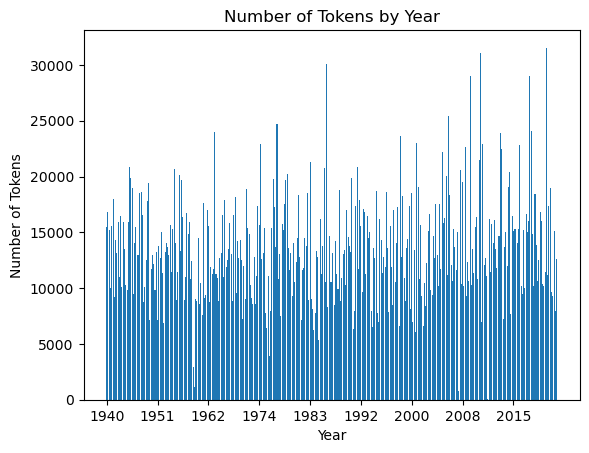

In [14]:
# Filter out rows with 'na' in the 'years' column
movie_subtitles_df = movie_subtitles_df[movie_subtitles_df['years'] != 'na']

# Sort the DataFrame by 'years' in ascending order
movie_subtitles_df = movie_subtitles_df.sort_values(by='years')

# Set x-axis ticks to show only once every other 20 years
step = 40  # Adjust the step value as needed
plt.xticks(range(0, len(movie_subtitles_df['years']), step), movie_subtitles_df['years'][::step])

# Create a bar chart
plt.bar(movie_subtitles_df.index, movie_subtitles_df['num_tokens'])
plt.xlabel('Year')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens by Year')

plt.show()

## Create Chunks of Tokens out of the Paragraphs

In [15]:
# Create a topic model based on chunking with chunk size 200 tokens

def generate_chunks(paragraphs, movie, year, chunk_size=200):
    chunks = []
    chunk_movie_name = []
    chunk_year = []

    for i in range(len(paragraphs)):
        text = paragraphs.iloc[i]  # Extract the text from the Series
        newsletter_type = movie.iloc[i]
        date = year.iloc[i]

        # Split the text into paragraphs using '\n'
        text_paragraphs = text.split('\n')

        current_chunk = []
        current_chunk_movie_name = []

        for paragraph in text_paragraphs:
            # Check if the length of the paragraph exceeds the chunk size
            if len(paragraph) > chunk_size:
                chunks.append(paragraph)
                chunk_movie_name.append(newsletter_type)
                chunk_year.append(date)
            else:
                # If not, add the paragraph to the current chunk
                current_chunk.append(paragraph)
                current_chunk_movie_name.append(newsletter_type)

                # Check if the current chunk size exceeds the specified limit
                if len(' '.join(current_chunk)) > chunk_size:
                    chunks.append(' '.join(current_chunk))
                    chunk_year.extend([date])
                    chunk_movie_name.append(newsletter_type)
                    current_chunk = []
                    current_chunk_movie_name = []

        # Add any remaining paragraphs to the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))
            chunk_year.extend([date])
            chunk_movie_name.append(newsletter_type)

    return chunks, chunk_movie_name, chunk_year

# Generate chunks
text_chunks, chunk_movie_name, chunk_year = generate_chunks(movie_subtitles_df['text'], movie_subtitles_df['name'], movie_subtitles_df['years'])

## Vectorize

In [16]:
# Vectorizer
vectorizer = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    #stop_words='english', # uncomment to remove fixed stops from input
    lowercase = True,
    min_df = 0.001, # Remember that we've chunked by paragraph
    max_df = 0.25    # Ditto
)

In [17]:
# Vectorize
vectorizer = TfidfVectorizer(use_idf=True, norm=None)

In [18]:
# Vectorized texts
X_chunked = vectorizer.fit_transform(text_chunks)

#X_topics_chunked = StandardScaler().fit_transform(lda.fit_transform(X_chunked))

## KMeans Cluster Analysis

In [19]:
y_pred = KMeans(n_clusters=3, n_init='auto').fit_predict(X_chunked)

In [20]:
# Plotting function
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        svd = TruncatedSVD(n_components=3)
        X_2d = svd.fit_transform(X)
    else:
        X_2d = X

    # initialize figsize in prompt
    plt.figure(figsize=(12, 6))

    # left subplot, alpha value in function cell
    plt.subplot(121)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=alpha)
    plt.title("Dimension-Reduced Unclustered Data")

    # right subplot, same coordinate data and supplied cluster labels, alpha value in function cell
    plt.subplot(122)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=alpha)
    plt.title("Data with Clustering")

    # Set the common title for the entire figure
    plt.title(title)

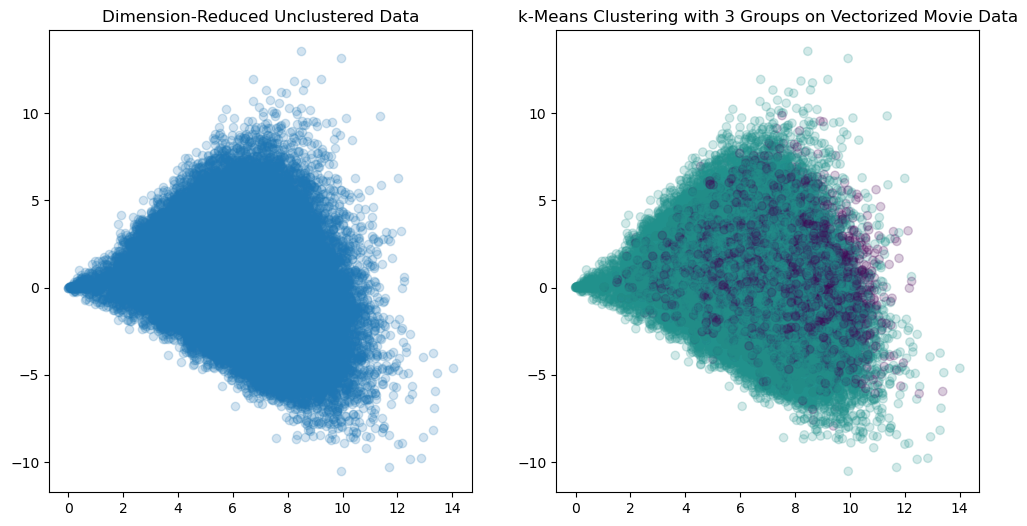

In [21]:
# plot resulting clustering
plot_compare(X_chunked, y_pred, 'k-Means Clustering with 3 Groups on Vectorized Movie Data')

# Topic Model

In [22]:
lda = LatentDirichletAllocation(
    n_components=20, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=0,       # Print progress
    max_iter=30,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X_chunked)

LatentDirichletAllocation(evaluate_every=0, max_iter=30, n_components=20,
                          n_jobs=-1)

In [23]:
def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)
        print(message)
    print()

In [24]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: sir hello yes the you mr please thank good to
Topic  1: bye you it the oh good thank beautiful and very
Topic  2: the of in and is its music earth wall by
Topic  3: dog sighs laughing blood trust mike eye game you your
Topic  4: new the and was year she it in york that
Topic  5: he him you to the wait his in ll what
Topic  6: you to it don what do me know that can
Topic  7: the 00 frank harry and of you meeting in paper
Topic  8: the of is to body and in rich professor human
Topic  9: the king lt yοu thе south north america tο san
Topic 10: door the music john fire david mama ray playing on
Topic 11: the of mr to and in is will that for
Topic 12: you hey on get it come right yeah gonna up
Topic 13: three the two five four fight years 000 minutes six
Topic 14: was the and of they ve that he you it
Topic 15: you ok it thinking yeah the no oh and coffee
Topic 16: the her and she in plane 12 of horse fly
Topic 17: sam la speaking english de vous french doc je fat
Topic 18: the of